In [129]:
# dependencies
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Data

In [103]:
import pandas as pd
# from sklearn.preprocessing import StandardScaler

# Load Data
train_data_path = 'data/train_data.csv'
pseudo_train_data_path = 'data/combined_labeled_data.csv'
test_data_path = 'data/test_data.csv'

train_data = pd.read_csv(train_data_path)
pseudo_train_data = pd.read_csv(pseudo_train_data_path)
test_data = pd.read_csv(test_data_path)

# Drop unnecessary columns
train_data = train_data.drop(columns=['DssTime','Event'])
test_data = test_data.drop(columns=['DssTime','Event'])

# # Scale Data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


In [115]:
# Create the dataset class
class CancerDataset(Dataset):
    def __init__(self, data, features, label_column):
        self.data = data
        self.features = features
        self.label_column = label_column
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        inputs = torch.tensor(self.data[self.features].iloc[idx].values, dtype=torch.float32)
        label = torch.tensor(self.data[self.label_column].iloc[idx], dtype=torch.float32)
        return inputs, label

# Define feature columns
train_columns = train_data.columns[0:30]
label_column = "Label"

# Create datasets and dataloaders
train_dataset = CancerDataset(train_data, train_columns, label_column)
test_dataset = CancerDataset(test_data, train_columns, label_column)  # Use same columns as during training

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model

In [105]:
# Define the unified Transformer binary classifier
class UnifiedTransformerBinaryClassifier(nn.Module):
    def __init__(self, input_dim, transformer_dim=64, num_heads=4, num_layers=2, dropout=0.1):
        super(UnifiedTransformerBinaryClassifier, self).__init__()
        
        # Define the transformer model
        self.embedding = nn.Linear(input_dim, transformer_dim)  # Linear layer to project input to transformer dim
        
        # Transformer Encoder Layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=num_heads, dropout=dropout),
            num_layers=num_layers
        )
        
        # Final classification layer
        self.fc = nn.Linear(transformer_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Apply the initial embedding to get input in the transformer dimension
        x = self.embedding(x)
        
        # Add a batch dimension (needed for the transformer)
        x = x.unsqueeze(1)  # Shape: [batch_size, 1, input_dim]
        
        # Pass through the transformer encoder
        x = self.transformer_encoder(x)
        
        # Get the output from the transformer (we'll use the last output for classification)
        x = x[:, -1, :]  # Shape: [batch_size, transformer_dim]
        
        # Classification layer
        x = self.fc(x)
        
        # Sigmoid activation for binary classification
        x = self.sigmoid(x)
        
        return x

# Training

In [137]:
# Define training loop
def train_model(model, train_loader, epochs, optimizer, loss_fn, device):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Send data to the device (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs).squeeze(1)
            
            # Compute loss
            loss = loss_fn(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

    # Plot the loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/50, Loss: 0.7660642067591349
Epoch 2/50, Loss: 0.7152413884798686
Epoch 3/50, Loss: 0.6917001883188884
Epoch 4/50, Loss: 0.6841438571612041
Epoch 5/50, Loss: 0.6742970267931621
Epoch 6/50, Loss: 0.6902182181676229
Epoch 7/50, Loss: 0.6604699810345968
Epoch 8/50, Loss: 0.649651825428009
Epoch 9/50, Loss: 0.6367985526720683
Epoch 10/50, Loss: 0.6166974186897278
Epoch 11/50, Loss: 0.6149043520291646
Epoch 12/50, Loss: 0.6199590643246968
Epoch 13/50, Loss: 0.6008542656898499
Epoch 14/50, Loss: 0.6164421975612641
Epoch 15/50, Loss: 0.6025389273961385
Epoch 16/50, Loss: 0.608788255850474
Epoch 17/50, Loss: 0.5966868360837301
Epoch 18/50, Loss: 0.5999678055445353
Epoch 19/50, Loss: 0.5853277623653412
Epoch 20/50, Loss: 0.5921361168225606
Epoch 21/50, Loss: 0.580008449157079
Epoch 22/50, Loss: 0.5956125219662984
Epoch 23/50, Loss: 0.586629190047582
Epoch 24/50, Loss: 0.5700044731299082
Epoch 25/50, Loss: 0.5806840896606446
Epoch 26/50, Loss: 0.5612665593624115
Epoch 27/50, Loss: 0.6151

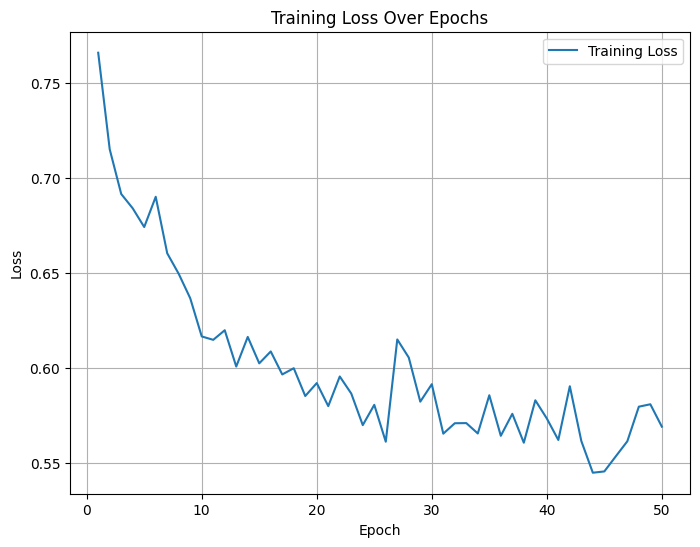

In [138]:
# Define the model, optimizer, and loss function
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper parameters
transformer_dim=64
num_heads=4
num_layers=2
dropout=0.1

input_dim = len(train_columns)  # Number of input features
model = UnifiedTransformerBinaryClassifier(input_dim, transformer_dim, num_heads, num_layers, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# Train the model
epochs = 50
train_model(model, train_loader, epochs, optimizer, loss_fn, device)

# Evaluation

In [117]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs).squeeze(1)  # Shape: [batch_size]
            preds = (outputs > 0.5).float()  # Binary classification (threshold 0.5)
            
            # Collect all predictions and true labels
            all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())
    
    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    # Print the results
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')
    
    return accuracy, precision, recall, f1, auc

In [126]:
# Evaluate the model
evaluate_model(model, test_loader, device)

Accuracy: 0.7350
Precision: 0.7627
Recall: 0.7258
F1-Score: 0.7438
AUC: 0.7356


(0.7350427350427351,
 0.7627118644067796,
 0.7258064516129032,
 0.743801652892562,
 0.7356304985337244)